In [1]:
from pathlib import Path
import torch
import numpy as np
import os

from torch import cuda
import pytorch_lightning as pl
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt

os.chdir("..")
from utils import io
from models_3 import SegmentationModel_1
from models_3 import SegmentationModel_2

/home/students/s265780/.conda-envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_1 = SegmentationModel_1.load_from_checkpoint(Path("reports/unet_3/unet_1/1-epoch=22-val_loss_segm=0.92-v1.ckpt"))
model_1.eval();

In [3]:
model_2 = SegmentationModel_2.load_from_checkpoint(Path("reports/unet_3/unet_3/2-epoch=15-val_loss=0.00.ckpt"))
model_2.eval();

In [4]:
input_path = Path("/home/students/s265780/data/24h_10mmMAX_OI")
test_date_9 = [
    "20190807", "20181030", "20200329", "20200501", "20190505", "20200128", "20180825",
    "20210807", "20210724", "20201006", "20210628", "20220518", "20190702", "20190802",
    "20210617", "20190806", "20200519", "20190618", "20180817", "20180801", "20190703",
    "20190714", "20220331", "20190906", "20181123", "20180720", "20200617", "20220524",
    "20190919", "20210730", "20190424", "20191218", "20200609", "20180607", "20181124",
    "20200801", "20210727", "20200420", "20211031", "20190828", "20190819", "20190412",
    "20200627", "20210101", "20181029", "20200701", "20200616", "20200426", "20180714",
    "20220528", "20200921", "20190908", "20200830", "20180813", "20191022", "20210831",
    "20180830", "20210712", "20191014", "20180820", "20190710", "20210129", "20211004"
]

indices_one, indices_zero, mask = io.get_mask_indices(input_path, True)
case_study_max=483.717752
available_models = ["bol00", "e1000", "c2200", "c5m00"]
x, y, in_features, out_features = io.load_data('unet', input_path, test_date_9, case_study_max, indices_one, indices_zero, available_models)

In [5]:
logit_model_1 = model_1(torch.from_numpy(x).to('cuda'))
pred_model_1 = torch.softmax(logit_model_1, dim=1).argmax(dim=1)
pred_model_1 = pred_model_1.to('cpu').numpy()

In [6]:
logit_model_2 = model_2(torch.from_numpy(x).to('cuda'), None)
pred_model_2 = logit_model_2.squeeze().to('cpu').detach().numpy()

In [7]:
y_1=torch.tensor(y).unsqueeze(1)
th_L=7
th_H=2
y_segm_L = torch.where(y_1<th_H/case_study_max, 1, 0).float()
y_segm_LH = torch.where((y_1<=th_L/case_study_max) & (y_1>=th_H/case_study_max), 1, 0).float()
y_segm_H = torch.where(y_1>th_L/case_study_max, 1, 0).float()
y_segm = torch.cat([y_segm_L, y_segm_LH, y_segm_H], dim=1)
y_segm = 0*y_segm_L + 1*y_segm_LH + 2*y_segm_H

Text(0.5, 1.0, 'model_pred_segm')

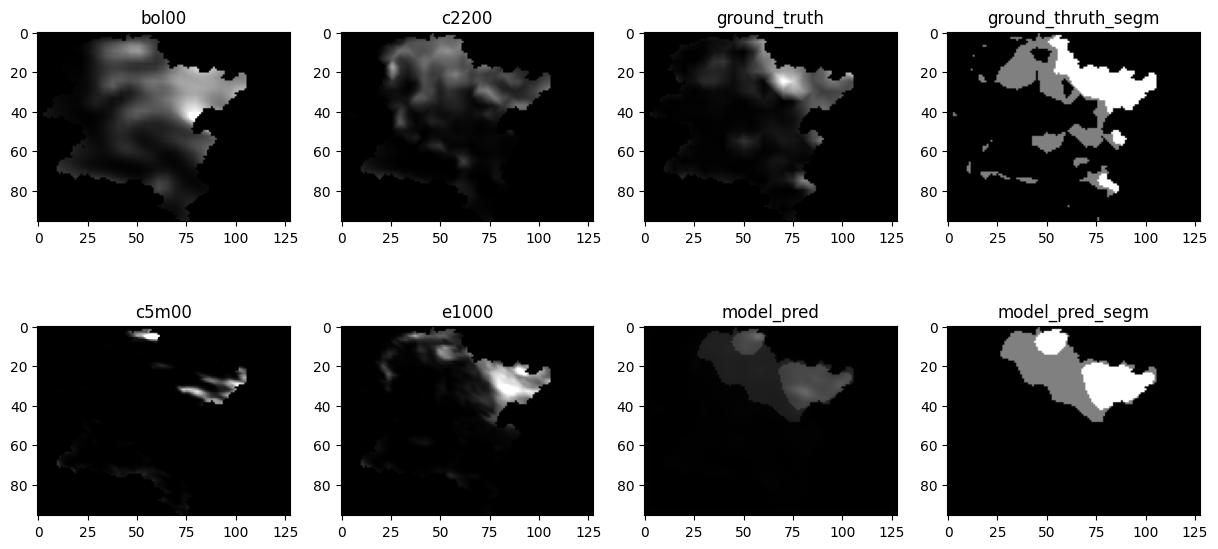

In [21]:
m=6
norm='linear'
vmin=0
vmax=1/15
fig, axs = plt.subplots(2, 4, figsize=(15, 7))
axs[0, 0].imshow(x[m][0], cmap='gray', norm=norm, vmin=vmin, vmax=vmax)
axs[0, 0].set_title('bol00')
axs[0, 1].imshow(x[m][1], cmap='gray', norm=norm, vmin=vmin, vmax=vmax)
axs[0, 1].set_title('c2200')
axs[1, 0].imshow(x[m][2], cmap='gray', norm=norm, vmin=vmin, vmax=vmax)
axs[1, 0].set_title('c5m00')
axs[1, 1].imshow(x[m][3], cmap='gray', norm=norm, vmin=vmin, vmax=vmax)
axs[1, 1].set_title('e1000')
axs[0, 2].imshow(y[m], cmap='gray', norm=norm, vmin=vmin, vmax=vmax)
axs[0, 2].set_title('ground_truth')
axs[1, 2].imshow(pred_model_2[m], cmap='gray', norm=norm, vmin=vmin, vmax=vmax)
axs[1, 2].set_title('model_pred')
axs[0, 3].imshow(y_segm[m].squeeze(), cmap='gray')
axs[0, 3].set_title('ground_thruth_segm')
axs[1, 3].imshow(pred_model_1[m].squeeze(), cmap='gray')
axs[1, 3].set_title('model_pred_segm')

Text(0.5, 1.0, 'model_pred_segm')

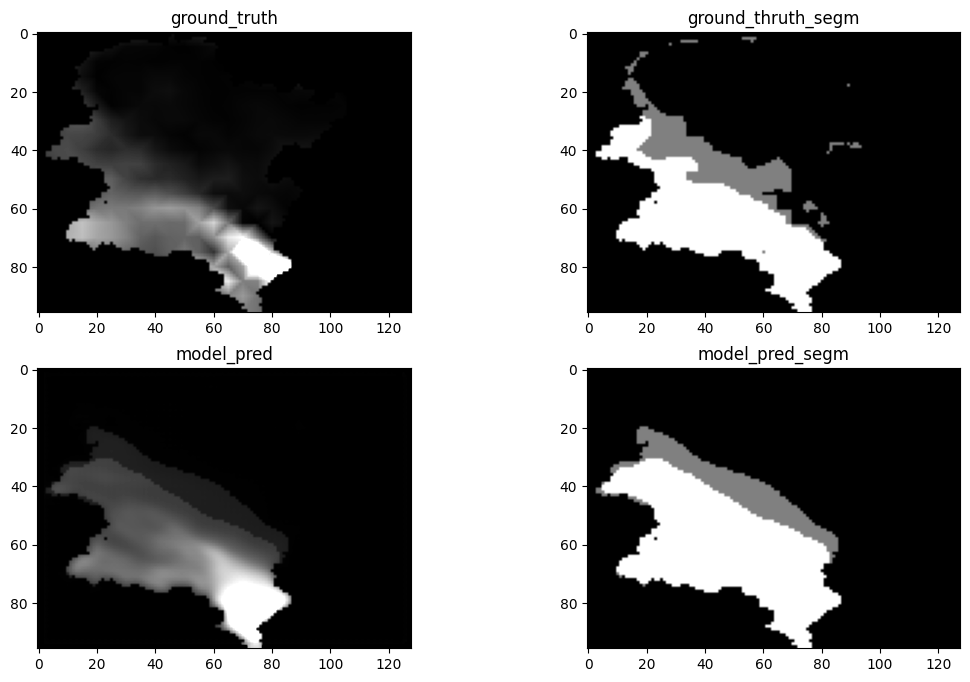

In [20]:
m=7
norm='linear'
vmin=0
vmax=1/15
fig, axs = plt.subplots(2, 2, figsize=(13, 8))
axs[0, 0].imshow(y[m], cmap='gray', norm=norm, vmin=vmin, vmax=vmax)
axs[0, 0].set_title('ground_truth')
axs[1, 0].imshow(pred_model_2[m], cmap='gray', norm=norm, vmin=vmin, vmax=vmax)
axs[1, 0].set_title('model_pred')
axs[0, 1].imshow(y_segm[m].squeeze(), cmap='gray')
axs[0, 1].set_title('ground_thruth_segm')
axs[1, 1].imshow(pred_model_1[m].squeeze(), cmap='gray')
axs[1, 1].set_title('model_pred_segm')

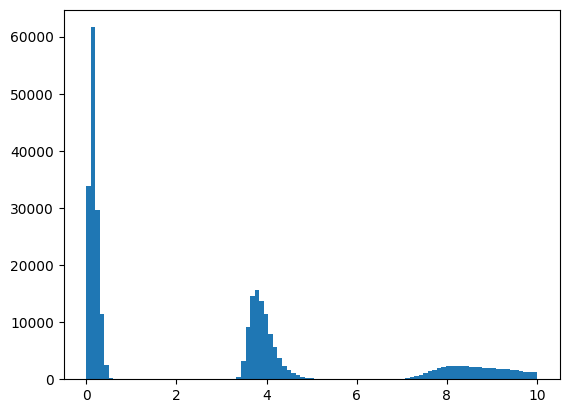

In [17]:
histo = (pred_model_2*case_study_max*mask).flatten()

plt.hist(histo[histo>0], bins=np.linspace(0,10, 100))
plt.show()

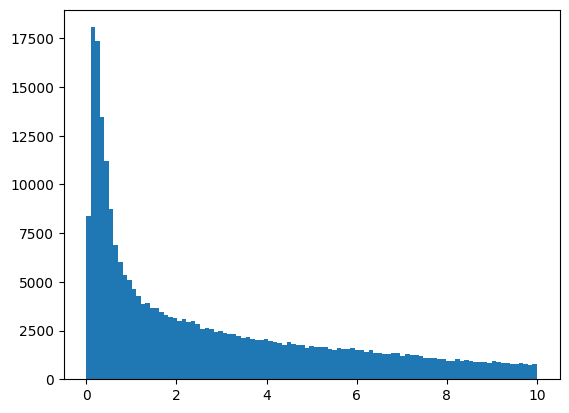

In [18]:
histo = (y*case_study_max*mask).flatten()

plt.hist(histo[histo>0], bins=np.linspace(0,10, 100))
plt.show()